# Overview in General
<br>  

This file contains a general overview of the data in the graph including node labels and relationships types.


In [6]:
# --- Path + CSV helpers (must be defined before loading CSVs) ---
import os
import pandas as pd
import matplotlib.pyplot as plt

# Prefer environment variable; fallback to ../reports relative to the notebook's folder
REPORTS_ROOT = os.environ.get(
    "REPORTS_DIRECTORY",
    os.path.abspath(os.path.join(os.getcwd(), "..", "reports"))
)
OVERVIEW_DIR = os.path.join(REPORTS_ROOT, "overview-csv")

def csv_path(filename: str) -> str:
    """Build absolute path to a CSV inside the overview-csv directory."""
    return os.path.join(OVERVIEW_DIR, filename)

def read_csv_or_empty(path: str) -> pd.DataFrame:
    """Read a CSV if it exists; otherwise return an empty DataFrame and warn."""
    if os.path.exists(path):
        try:
            return pd.read_csv(path)
        except Exception as e:
            print(f"[warn] Failed to read CSV: {path} -> {e}")
            return pd.DataFrame()
    else:
        print(f"[warn] Missing CSV: {path}")
        return pd.DataFrame()

print("REPORTS_ROOT =", REPORTS_ROOT)
print("OVERVIEW_DIR =", OVERVIEW_DIR)


REPORTS_ROOT = /Users/jonathan.nervaez/Documents/AppModPractice/E2E-decomposition/reports
OVERVIEW_DIR = /Users/jonathan.nervaez/Documents/AppModPractice/E2E-decomposition/reports/overview-csv


In [7]:
# ---------- Load CSVs ----------
df_node_label_count          = read_csv_or_empty(csv_path("NodeLabelCount.csv"))
df_rel_type_count            = read_csv_or_empty(csv_path("RelationshipTypeCount.csv"))
df_labels_and_relationships  = read_csv_or_empty(csv_path("NodeLabelsAndRelationships.csv"))
df_overview_size             = read_csv_or_empty(csv_path("OverviewSize.csv"))
df_packages_per_artifact     = read_csv_or_empty(csv_path("NumberOfPackagesPerArtifact.csv"))
df_types_per_artifact        = read_csv_or_empty(csv_path("NumberOfTypesPerArtifact.csv"))

# Peek shapes for quick sanity check
print("NodeLabelCount:", df_node_label_count.shape)
print("RelationshipTypeCount:", df_rel_type_count.shape)
print("NodeLabelsAndRelationships:", df_labels_and_relationships.shape)
print("OverviewSize:", df_overview_size.shape)
print("NumberOfPackagesPerArtifact:", df_packages_per_artifact.shape)
print("NumberOfTypesPerArtifact:", df_types_per_artifact.shape)


NodeLabelCount: (74, 4)
RelationshipTypeCount: (74, 4)
NodeLabelsAndRelationships: (578, 8)
OverviewSize: (1, 8)
NumberOfPackagesPerArtifact: (1, 3)
NumberOfTypesPerArtifact: (4, 5)


In [8]:
# ---------- Quick tables (head) ----------
display(df_node_label_count.head(10))
display(df_rel_type_count.head(10))
display(df_labels_and_relationships.head(10))
display(df_overview_size.head(10))
display(df_packages_per_artifact.head(10))
display(df_types_per_artifact.head(10))


,nodeLabel,nodesWithThatLabel,nodesWithThatLabelPercent,Source Cypher File: Overview/Node_label_count.cypher
0,Java,3252187,88.996875,NaN
1,ByteCode,3242983,88.745006,NaN
2,Member,1448193,39.630148,NaN
3,Method,1113223,30.463614,NaN
4,Parameter,860210,23.539852,NaN
5,Bound,582685,15.945314,NaN
6,Field,334970,9.166534,NaN
7,Xml,289757,7.929270,NaN
8,Value,273518,7.484885,NaN
9,ParameterizedType,192011,5.254427,NaN


,relationshipType,nodesWithThatRelationshipType,nodesWithThatRelationshipTypePercent,Source Cypher File: Overview/Relationship_type_count.cypher
0,INVOKES,3094986,22.234176,NaN
1,DECLARES,1488648,10.694350,NaN
2,OF_TYPE,1473110,10.582726,NaN
3,DEPENDS_ON,1383899,9.941840,NaN
4,READS,1197812,8.605003,NaN
5,HAS,1000532,7.187756,NaN
6,RETURNS,908690,6.527969,NaN
7,OF_RAW_TYPE,564554,4.055719,NaN
8,WRITES,410412,2.948373,NaN
9,THROWS,301314,2.164620,NaN


,sourceLabels,relationType,targetLabels,numberOfRelationships,numberOfNodesWithSameLabelsAsSource,numberOfNodesWithSameLabelsAsTarget,densityInPercent,Source Cypher File: Overview/Node_labels_and_their_relationships.cypher
0,"Java,ByteCode,Member,Method",INVOKES,"Java,ByteCode,Member,Method",2405927,952879,952879,0.000265,NaN
1,"Java,ByteCode,Member,Method",READS,"Java,ByteCode,Member,Field",1146692,952879,334970,0.000359,NaN
2,"Java,ByteCode,Member,Method",HAS,"Java,ByteCode,Parameter",661222,952879,860210,0.000081,NaN
3,"Type,File,Java,Class,ByteCode",DECLARES,"Java,ByteCode,Member,Method",649203,66098,952879,0.001031,NaN
4,"Java,ByteCode,Parameter",OF_TYPE,"Type,File,Java,ByteCode",595207,860210,50408,0.001373,NaN
5,"Type,File,Java,Class,ByteCode",DEPENDS_ON,"Type,File,Java,ByteCode",556876,66098,50408,0.016714,NaN
6,"Java,ByteCode,Member,Method",RETURNS,"Type,File,Java,ByteCode",543346,952879,50408,0.001131,NaN
7,"Java,ByteCode,Member,Method",INVOKES,"Java,ByteCode,Member,Constructor,Method",320795,952879,138666,0.000243,NaN
8,"Type,File,Java,Class,ByteCode",DEPENDS_ON,"Type,File,Java,Class,ByteCode",275001,66098,66098,0.006294,NaN
9,"Type,File,Java,Class,ByteCode",DECLARES,"Java,ByteCode,Member,Field",254968,66098,334970,0.001152,NaN


,nodeCount,relationshipCount,artifactCount,packageCount,typeCount,methodCount,memberCount,Source Cypher File: Overview/Overview_size.cypher
0,3654271,13919949,311,5926,97981,375242,544284,NaN


,artifactName,numberOfPackages,Source Cypher File: Overview/Number_of_packages_per_artifact.cypher
0,NaN,4684,NaN


,artifactName,numberOfArtifactTypes,languageElement,numberOfTypes,Source Cypher File: Overview/Number_of_types_per_artifact.cypher
0,NaN,91774,Class,73999,NaN
1,NaN,91774,Interface,12460,NaN
2,NaN,91774,Enum,4124,NaN
3,NaN,91774,Annotation,1458,NaN


In [9]:
# ---------- Totals & density ----------
# Try to read totals from OverviewSize.csv if it provides them. Otherwise, fallback to sums.
total_nodes = None
total_relationships = None

# Heuristic: try common column names
for col in ["nodes", "totalNodes", "node_count"]:
    if col in df_overview_size.columns:
        total_nodes = int(df_overview_size[col].sum())
        break

for col in ["relationships", "totalRelationships", "relationship_count"]:
    if col in df_overview_size.columns:
        total_relationships = int(df_overview_size[col].sum())
        break

# Fallbacks (infer from detail CSVs)
if total_nodes is None and "nodesWithThatLabel" in df_node_label_count.columns:
    total_nodes = int(df_node_label_count["nodesWithThatLabel"].sum())

if total_relationships is None and "nodesWithThatRelationshipType" in df_rel_type_count.columns:
    total_relationships = int(df_rel_type_count["nodesWithThatRelationshipType"].sum())

print("total_number_of_nodes (vertices):", total_nodes)
print("total_number_of_relationships (edges):", total_relationships)

if total_nodes and total_nodes > 1 and total_relationships is not None:
    directed_density = total_relationships / (total_nodes * (total_nodes - 1))
    print("-> total directed graph density:", directed_density)
    print("-> total directed graph density in percent:", directed_density * 100)
else:
    print("[info] Not enough data to compute density.")


total_number_of_nodes (vertices): 12931953
total_number_of_relationships (edges): 13919949
-> total directed graph density: 8.323566289016638e-08
-> total directed graph density in percent: 8.323566289016637e-06


,nodeLabel,nodesWithThatLabel,nodesWithThatLabelPercent,Source Cypher File: Overview/Node_label_count.cypher
0,Java,3252187,88.996875,NaN
1,ByteCode,3242983,88.745006,NaN
2,Member,1448193,39.630148,NaN
3,Method,1113223,30.463614,NaN
4,Parameter,860210,23.539852,NaN
5,Bound,582685,15.945314,NaN
6,Field,334970,9.166534,NaN
7,Xml,289757,7.929270,NaN
8,Value,273518,7.484885,NaN
9,ParameterizedType,192011,5.254427,NaN


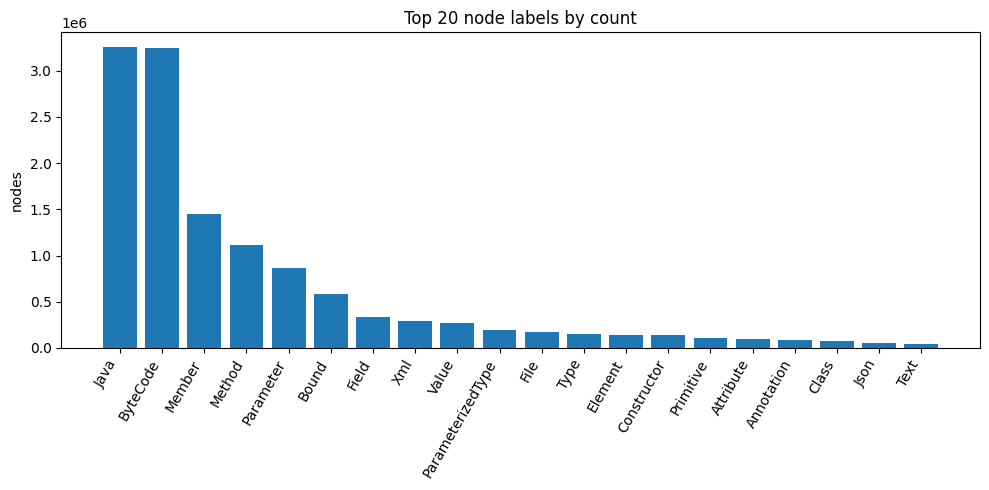

In [10]:
# ---------- Top node labels ----------
if not df_node_label_count.empty and "nodeLabel" in df_node_label_count.columns and "nodesWithThatLabel" in df_node_label_count.columns:
    top_labels = (df_node_label_count
                  .sort_values("nodesWithThatLabel", ascending=False)
                  .head(20))
    display(top_labels)

    plt.figure(figsize=(10, 5))
    # Do not set any explicit colors; let matplotlib choose defaults
    plt.bar(top_labels["nodeLabel"].astype(str), top_labels["nodesWithThatLabel"])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("nodes")
    plt.title("Top 20 node labels by count")
    plt.tight_layout()
    plt.show()
else:
    print("[info] NodeLabelCount.csv missing required columns.")


,relationshipType,nodesWithThatRelationshipType,nodesWithThatRelationshipTypePercent,Source Cypher File: Overview/Relationship_type_count.cypher
0,INVOKES,3094986,22.234176,NaN
1,DECLARES,1488648,10.694350,NaN
2,OF_TYPE,1473110,10.582726,NaN
3,DEPENDS_ON,1383899,9.941840,NaN
4,READS,1197812,8.605003,NaN
5,HAS,1000532,7.187756,NaN
6,RETURNS,908690,6.527969,NaN
7,OF_RAW_TYPE,564554,4.055719,NaN
8,WRITES,410412,2.948373,NaN
9,THROWS,301314,2.164620,NaN


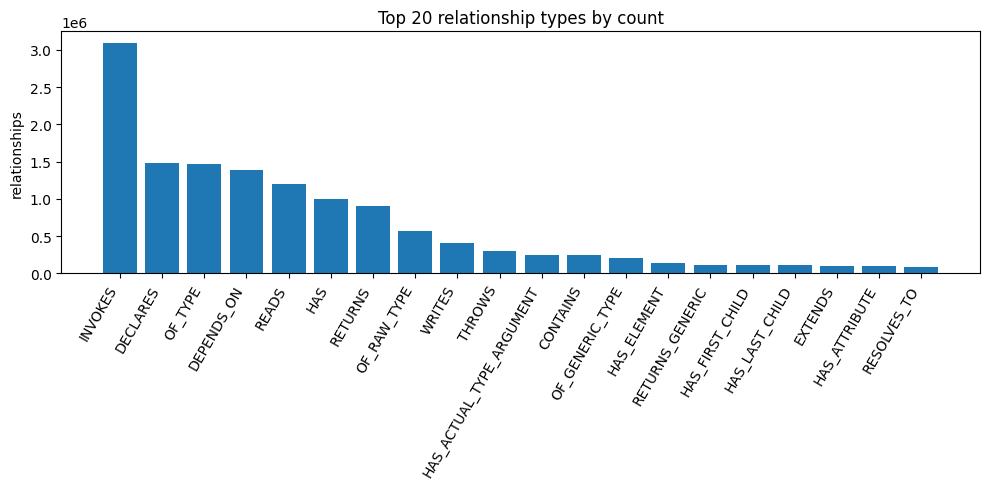

In [11]:
# ---------- Top relationship types ----------
if not df_rel_type_count.empty and "relationshipType" in df_rel_type_count.columns and "nodesWithThatRelationshipType" in df_rel_type_count.columns:
    top_rels = (df_rel_type_count
                .sort_values("nodesWithThatRelationshipType", ascending=False)
                .head(20))
    display(top_rels)

    plt.figure(figsize=(10, 5))
    plt.bar(top_rels["relationshipType"].astype(str), top_rels["nodesWithThatRelationshipType"])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("relationships")
    plt.title("Top 20 relationship types by count")
    plt.tight_layout()
    plt.show()
else:
    print("[info] RelationshipTypeCount.csv missing required columns.")


,artifactName,numberOfPackages,Source Cypher File: Overview/Number_of_packages_per_artifact.cypher
0,NaN,4684,NaN


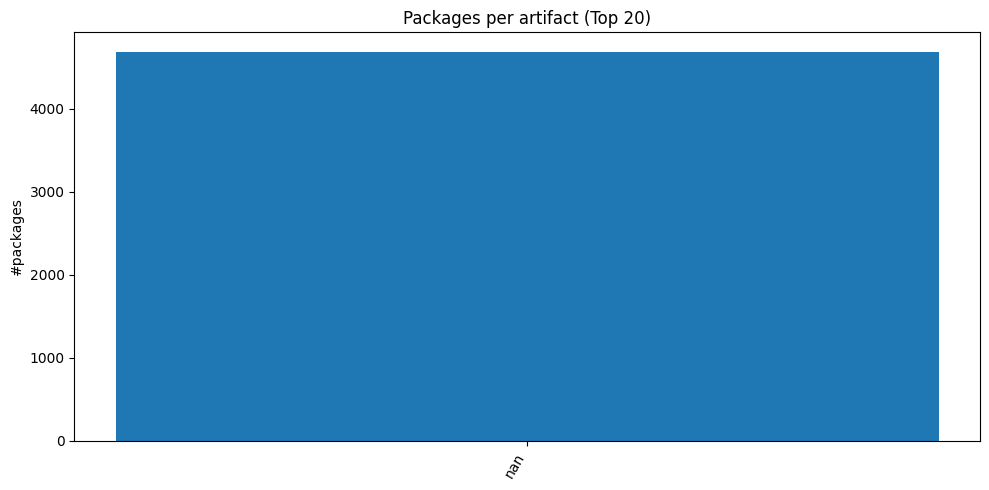

,artifactName,numberOfArtifactTypes,languageElement,numberOfTypes,Source Cypher File: Overview/Number_of_types_per_artifact.cypher
0,NaN,91774,Class,73999,NaN
1,NaN,91774,Interface,12460,NaN
2,NaN,91774,Enum,4124,NaN
3,NaN,91774,Annotation,1458,NaN


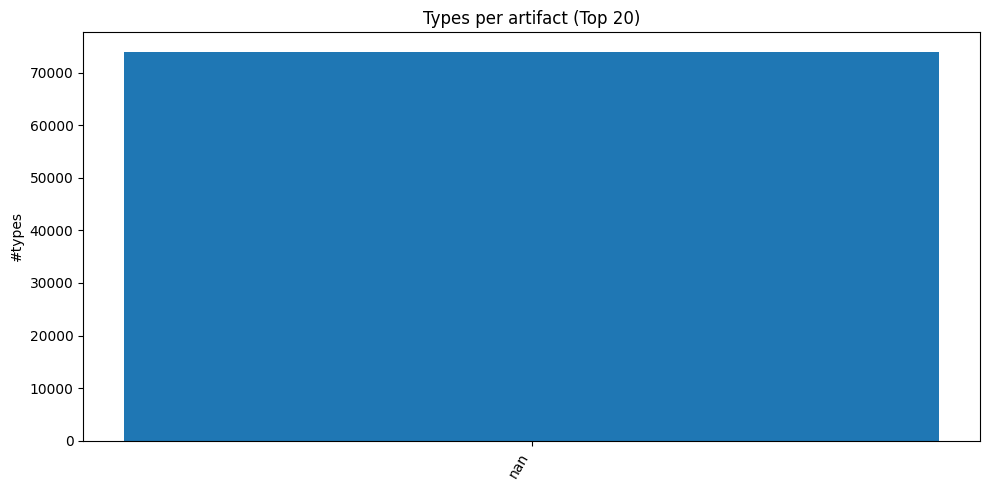

In [12]:
# ---------- Packages per artifact ----------
if not df_packages_per_artifact.empty:
    # Try to guess column names
    # Common: artifact.fileName / numberOfPackages
    cols = df_packages_per_artifact.columns
    candidate_artifact = None
    for c in ["artifact.fileName", "artifact", "fileName", "name", "artifactName"]:
        if c in cols:
            candidate_artifact = c
            break
    candidate_value = "numberOfPackages" if "numberOfPackages" in cols else None

    if candidate_artifact and candidate_value:
        top_pkgs = df_packages_per_artifact.sort_values(candidate_value, ascending=False).head(20)
        display(top_pkgs.head(10))

        plt.figure(figsize=(10, 5))
        plt.bar(top_pkgs[candidate_artifact].astype(str), top_pkgs[candidate_value])
        plt.xticks(rotation=60, ha="right")
        plt.ylabel("#packages")
        plt.title("Packages per artifact (Top 20)")
        plt.tight_layout()
        plt.show()
    else:
        print("[info] NumberOfPackagesPerArtifact.csv missing expected columns.")
else:
    print("[info] NumberOfPackagesPerArtifact.csv not found or empty.")

# ---------- Types per artifact ----------
if not df_types_per_artifact.empty:
    cols = df_types_per_artifact.columns
    candidate_artifact = None
    for c in ["artifact.fileName", "artifact", "fileName", "name", "artifactName"]:
        if c in cols:
            candidate_artifact = c
            break
    candidate_value = "numberOfTypes" if "numberOfTypes" in cols else None

    if candidate_artifact and candidate_value:
        top_types = df_types_per_artifact.sort_values(candidate_value, ascending=False).head(20)
        display(top_types.head(10))

        plt.figure(figsize=(10, 5))
        plt.bar(top_types[candidate_artifact].astype(str), top_types[candidate_value])
        plt.xticks(rotation=60, ha="right")
        plt.ylabel("#types")
        plt.title("Types per artifact (Top 20)")
        plt.tight_layout()
        plt.show()
    else:
        print("[info] NumberOfTypesPerArtifact.csv missing expected columns.")
else:
    print("[info] NumberOfTypesPerArtifact.csv not found or empty.")


In [13]:
# ---------- Node labels with their relationships ----------
if not df_labels_and_relationships.empty:
    display(df_labels_and_relationships.head(30))
else:
    print("[info] NodeLabelsAndRelationships.csv not found or empty.")


,sourceLabels,relationType,targetLabels,numberOfRelationships,numberOfNodesWithSameLabelsAsSource,numberOfNodesWithSameLabelsAsTarget,densityInPercent,Source Cypher File: Overview/Node_labels_and_their_relationships.cypher
0,"Java,ByteCode,Member,Method",INVOKES,"Java,ByteCode,Member,Method",2405927,952879,952879,0.000265,NaN
1,"Java,ByteCode,Member,Method",READS,"Java,ByteCode,Member,Field",1146692,952879,334970,0.000359,NaN
2,"Java,ByteCode,Member,Method",HAS,"Java,ByteCode,Parameter",661222,952879,860210,0.000081,NaN
3,"Type,File,Java,Class,ByteCode",DECLARES,"Java,ByteCode,Member,Method",649203,66098,952879,0.001031,NaN
4,"Java,ByteCode,Parameter",OF_TYPE,"Type,File,Java,ByteCode",595207,860210,50408,0.001373,NaN
5,"Type,File,Java,Class,ByteCode",DEPENDS_ON,"Type,File,Java,ByteCode",556876,66098,50408,0.016714,NaN
6,"Java,ByteCode,Member,Method",RETURNS,"Type,File,Java,ByteCode",543346,952879,50408,0.001131,NaN
7,"Java,ByteCode,Member,Method",INVOKES,"Java,ByteCode,Member,Constructor,Method",320795,952879,138666,0.000243,NaN
8,"Type,File,Java,Class,ByteCode",DEPENDS_ON,"Type,File,Java,Class,ByteCode",275001,66098,66098,0.006294,NaN
9,"Type,File,Java,Class,ByteCode",DECLARES,"Java,ByteCode,Member,Field",254968,66098,334970,0.001152,NaN
